In [1]:
#-*- coding: UTF-8 -*-
import numpy as np
import pandas as pd
import lightgbm as lgb

from sklearn.metrics import f1_score,accuracy_score,roc_auc_score,log_loss, precision_score, recall_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder,LabelBinarizer
import gc
import seaborn as sns
import matplotlib.pyplot as plt
pd.options.display.max_columns=50
pd.options.display.max_rows=5

In [2]:
# 训练集读取，45146*30，其中有标签的15215*30
train_data = pd.read_csv('base_train_sum.csv', encoding = 'gbk')
train_data = pd.merge(train_data,pd.read_csv('knowledge_train_sum.csv', encoding = 'gbk'),how='left',on='ID')
train_data = pd.merge(train_data,pd.read_csv('money_report_train_sum.csv', encoding = 'gbk'),how='left',on='ID')
train_data = pd.merge(train_data,pd.read_csv('year_report_train_sum.csv', encoding = 'gbk'),how='left',on=['ID','year']) # 这样就能一起合并
train_data = train_data[~train_data['flag'].isnull()].reset_index(drop=True)

# 验证集读取，96250*31，其中有标签的91732*30（注：比训练集多了一个控制人ID，官方回复测试集中不会加入这个特征，所以选择删除）
valid_data = pd.read_csv('base_verify1.csv', encoding = 'gbk')
valid_data = pd.merge(valid_data,pd.read_csv('paient_information_verify1.csv', encoding = 'gbk'),how='left',on='ID')
valid_data = pd.merge(valid_data,pd.read_csv('money_information_verify1.csv', encoding = 'gbk'),how='left',on='ID')
valid_data = pd.merge(valid_data,pd.read_csv('year_report_verify1.csv', encoding = 'gbk'),how='left',on=['ID','year'])
del valid_data['控制人ID']

# 合并为一个数据集，137796*30
data = pd.concat([train_data,valid_data],axis=0,sort=False,ignore_index=True)
data.columns = ['ID','Registration Time', 'Registered Capital', 'Industry', 'Region', 'Business Type', 'Controlling Type', 'Controlling Shareholding','flag', 'Patent', 'Trademark', 'Copyright', 'year', 'Debt financing line', 'Debt financing cost', 'Equity financing line', 'Equity financing cost', 'Internal financing and trade financing line', 'Internal financing and trade financing cost', 'Project financing and Policy financing quota ',' Project financing and policy financing costs', 'Number of employees',' Total assets', 'Total liabilities',' Total operating income ',' Main operating income ',' Total profit ' , 'Net Profit', 'Total Taxes', 'Total Owners Equity']

# 去flag=null的值，现在data:106947*30
data = data[~data['flag'].isnull()].reset_index(drop=True)

# 去重
data = data.drop_duplicates(subset=None,keep='first',inplace=False)

data = data.sample(frac=1).reset_index(drop=True) # 打乱数据

In [3]:
#labelencode
#['Industry', 'Region', 'Business Type', 'Controlling Type']
#['行业','区域','企业类型','控制人类型']
for col in ['Industry', 'Region', 'Business Type', 'Controlling Type']:
    lbl = LabelEncoder()
    data[col] = lbl.fit_transform(data[col].astype(str))

In [4]:
y = data['flag']
del data['flag']
# del data['ID']

In [5]:
# 特征生成

# data['Total Taxes Square'] = data['Total Taxes']**2

In [6]:
data

,ID,Registration Time,Registered Capital,Industry,Region,Business Type,Controlling Type,Controlling Shareholding,Patent,Trademark,Copyright,year,Debt financing line,Debt financing cost,Equity financing line,Equity financing cost,Internal financing and trade financing line,Internal financing and trade financing cost,Project financing and Policy financing quota,Project financing and policy financing costs,Number of employees,Total assets,Total liabilities,Total operating income,Main operating income,Total profit,Net Profit,Total Taxes,Total Owners Equity
0,5981586,2009.0,2630.0,4,2,4,1,1.00,0.0,0.0,0.0,2016.0,0.0,0.00,0.0,0.0,0.0,0.000,184.1,11.046,685.0,18410.0,23670.0,42343.0,21171.5,21171.5,0.0,NaN,-5260.0
1,5991892,2012.0,2980.0,5,2,2,2,0.81,1.0,0.0,1.0,2016.0,0.0,0.00,0.0,0.0,18595.2,1115.712,0.0,0.000,926.0,23840.0,31290.0,61984.0,37190.4,24793.6,0.0,37190.4,-7450.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106945,2859839,2007.0,4370.0,2,4,3,2,0.74,0.0,0.0,1.0,2015.0,13984.0,1118.72,0.0,0.0,0.0,0.000,0.0,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
106946,5988725,2013.0,7000.0,5,1,4,2,0.66,0.0,0.0,0.0,2017.0,5600.0,448.00,0.0,0.0,0.0,0.000,0.0,0.000,219.0,56000.0,24500.0,5600.0,2800.0,2800.0,2240.0,1120.0,31500.0


In [7]:
params1 = {
            'boosting_type': 'gbdt',   # 传统梯度提升树类型
            'max_depth': 6,  # 树的最大深度，减少可降低过拟合
            'num_leaves': 31, # 叶子数量，取值应 <= 2 ^（max_depth）， 超过此值容易导致过拟合
            'objective': 'binary',  # binary用作二分类，regression用于回归，multiclass用于多分类
            
            'metric': ['auc', 'binary_logloss'],  # 衡量指标，可选有cross_entropy, binary_logloss,auc等
            #'first_metric_only':True,
            'learning_rate': 0.01,
            
            'min_data_in_leaf':20,  # 叶子具有的最小记录数，默认为20，设置较大能减少树的深度，但有可能导致欠拟合
            'feature_fraction': 0.8,
            'bagging_fraction': 0.8,
            #'bagging_freq': 20,
            #'reg_alpha': 3.77, 
            #'reg_lambda': 5.86,
        }

In [8]:
#初步划分训练、测试、验证集

train_vaild_line = int(data.shape[0]*0.8)
valid_test_line = int(data.shape[0]*0.9)

test = data[valid_test_line:].reset_index(drop=True)
test_y = y[valid_test_line:].reset_index(drop=True)

train = data[:train_vaild_line]
train_y = y[:train_vaild_line]
valid = data[train_vaild_line:valid_test_line].reset_index(drop=True) # 取13000作为验证集
valid_y = y[train_vaild_line:valid_test_line].reset_index(drop=True)



In [9]:
train

,ID,Registration Time,Registered Capital,Industry,Region,Business Type,Controlling Type,Controlling Shareholding,Patent,Trademark,Copyright,year,Debt financing line,Debt financing cost,Equity financing line,Equity financing cost,Internal financing and trade financing line,Internal financing and trade financing cost,Project financing and Policy financing quota,Project financing and policy financing costs,Number of employees,Total assets,Total liabilities,Total operating income,Main operating income,Total profit,Net Profit,Total Taxes,Total Owners Equity
0,5981586,2009.0,2630.0,4,2,4,1,1.00,0.0,0.0,0.0,2016.0,0.0,0.0,0.00,0.0000,0.0,0.000,184.1,11.046,685.0,18410.0,23670.0,42343.0,21171.5,21171.5,0.0,NaN,-5260.0
1,5991892,2012.0,2980.0,5,2,2,2,0.81,1.0,0.0,1.0,2016.0,0.0,0.0,0.00,0.0000,18595.2,1115.712,0.0,0.000,926.0,23840.0,31290.0,61984.0,37190.4,24793.6,0.0,37190.4,-7450.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85555,3045474,2011.0,4610.0,6,7,1,2,0.96,1.0,1.0,0.0,2016.0,0.0,0.0,12908.00,516.3200,0.0,0.000,0.0,0.000,442.0,46100.0,41490.0,161350.0,129080.0,64540.0,-16135.0,0.0,4610.0
85556,5999794,2006.0,3330.0,4,7,1,2,0.99,1.0,0.0,0.0,2017.0,0.0,0.0,5054.94,202.1976,0.0,0.000,0.0,0.000,551.0,36630.0,33300.0,84249.0,58974.3,25274.7,33699.6,33699.6,3330.0


In [10]:
# 获取特征名
feature_name = [col for col in data.columns if col not in ['ID','flag']]
train = lgb.Dataset(train[feature_name], label=train_y)
valid = lgb.Dataset(valid[feature_name], label=valid_y)

In [11]:
%time lgb_model=lgb.train(params1, train, num_boost_round=1000, valid_sets=valid, verbose_eval=100, early_stopping_rounds=100)

Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.922719	valid_0's binary_logloss: 0.370393
Early stopping, best iteration is:
[65]	valid_0's auc: 0.923387	valid_0's binary_logloss: 0.432843
Wall time: 976 ms


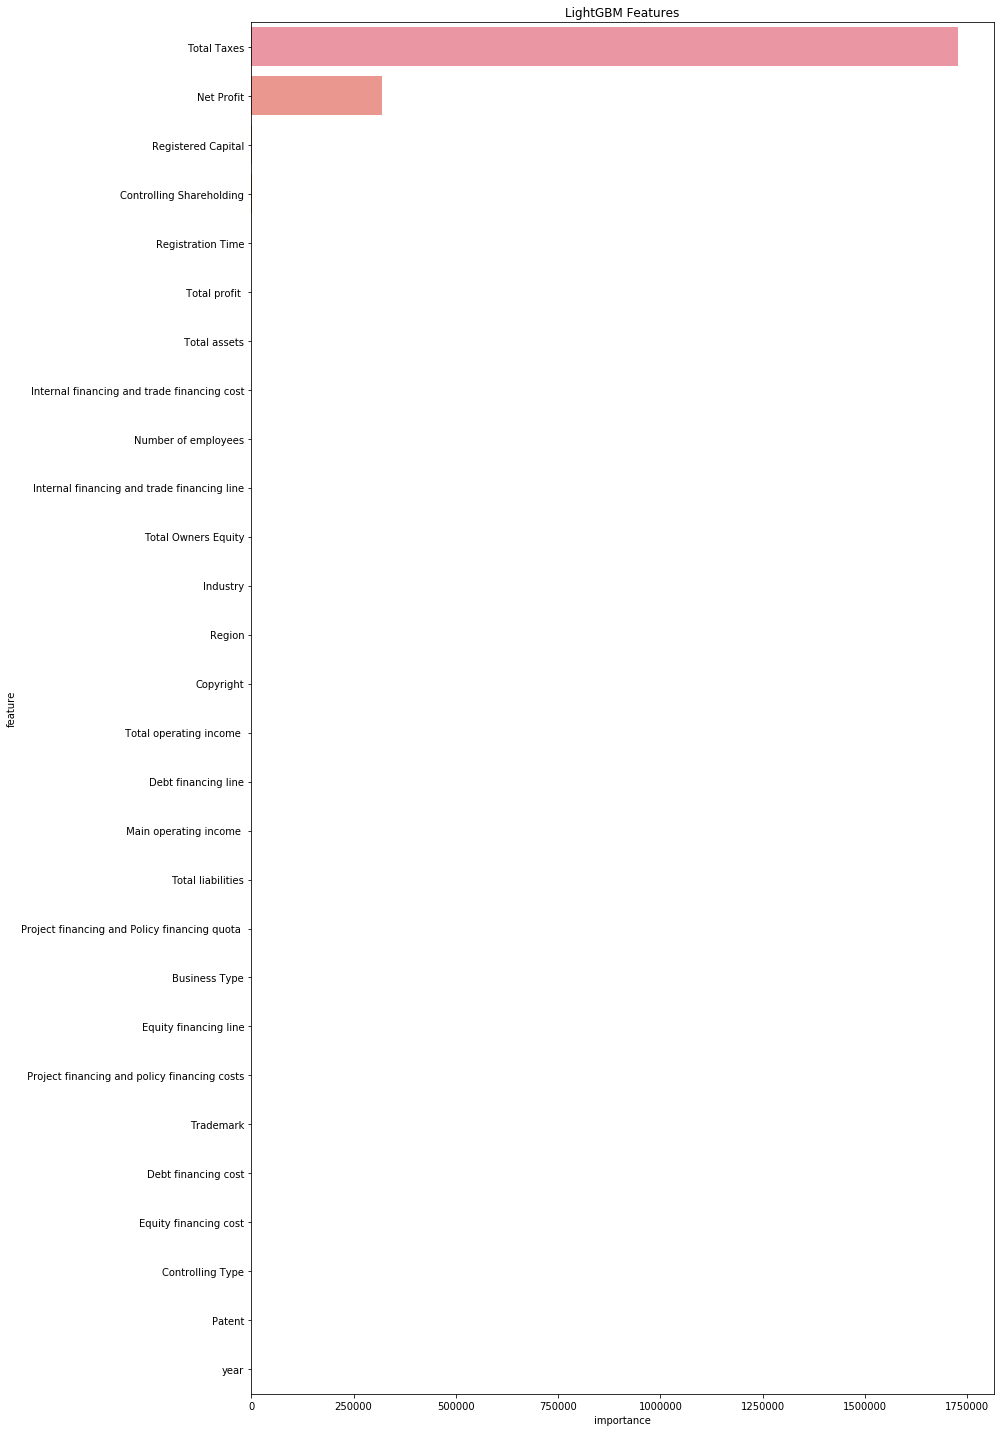

In [12]:
# 打印特征重要度
# feature_name = ['Net Profit', 'Total Taxes']这两个特征重要性异常高
feature_importance_df = pd.DataFrame({'feature':feature_name, 'importance':lgb_model.feature_importance(importance_type='gain')})
# df的排序方法，axis = 0 根据每行值大小排序
feature_importance_df = feature_importance_df.sort_values(by = 'importance',axis = 0, ascending=False)

plt.figure(figsize=(14,20))
sns.barplot(x="importance", y="feature", data=feature_importance_df)
plt.title('LightGBM Features')
plt.tight_layout()

In [13]:
result = lgb_model.predict(test[feature_name])
result = np.where(result>=0.5,1,0)

In [14]:
sum(test_y)

4231.0

In [18]:
print('准确率：', accuracy_score(test_y,result))   # 准确率 （TP+TN）/（TP+TN+FN+FP）
print('精确率：', precision_score(test_y,result))  # 精确率  TP  / (TP+ FP)
print('召回率：', recall_score(test_y, result))    # 召回率  TP / (TP + FN)

准确率： 0.8989247311827957
精确率： 0.8063010501750292
召回率： 0.9799101867170882


In [16]:
sum(result)

5142